# Proyecto 1.1. Modelo de lenguaje basado en redes neuronales

Este proyecto tiene como finalidad realizar la predicción de la siguiente palabra ante una secuencia de texto. El objetivo principal es implementar un modelo de MLP simple con embeddings y trigramas para dicha predicción.

Desarrollo:
* Seleccionar y preparar un corpus de texto propio (dominio libre o de interés académico).
* Construir un vocabulario y representación de tokens eficiente.
Implementar un embedding fijo (dimensión establecida; el alumno decide si lo congela o lo entrena).
* Diseñar y entrenar un MLP de predicción de la siguiente palabra usando una ventana de contexto de 3 palabras (trigrama deslizante).
* Separar entrenamiento/prueba, monitorear loss, accuracy y perplexity.
Generar texto breve con el modelo entrenado.


Adquisición de los datos a través de kagglehub.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("neisse/scrapped-lyrics-from-6-genres")

print("Path to dataset files:", path)

c:\Users\bugy1\anaconda3\envs\pln\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\bugy1\.cache\kagglehub\datasets\neisse\scrapped-lyrics-from-6-genres\versions\3


In [2]:
import pandas as pd

file_name = 'lyrics-data.csv'
complete_route = path + '/' + file_name
df = pd.read_csv(complete_route)
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


Verificación de los lenguajes en el dataset.

In [3]:
languages = df['language'].unique()
print("Lenguajes disponibles: ",languages)

Lenguajes disponibles:  ['pt' 'es' 'en' nan 'it' 'gl' 'fr' 'de' 'tl' 'et' 'fi' 'pl' 'da' 'st' 'sv'
 'ro' 'af' 'no' 'eu' 'rw' 'sw' 'ga' 'cy' 'ca' 'ny' 'ko' 'ar' 'gd' 'tr'
 'id' 'su' 'lg' 'ru' 'nl' 'sq' 'is' 'cs' 'jw' 'lv' 'hu' 'ms' 'ku' 'zh'
 'hr' 'ht' 'fa' 'mg' 'vi' 'ja' 'hmn' 'sr' 'iw' 'sl']


En este proyecto únicamente se realizarán predicciones en inglés. Con la finalidad de evitar tiempos prolongados, únicamente se elegirán 1000 canciones para el análisis.

In [4]:
df_en = df[df['language'] == 'en'].head(1000)
print("Longitud del dataset: ",len(df_en))
df_en.head()

Longitud del dataset:  1000


,ALink,SName,SLink,Lyric,language
69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en


Para la parte del preprocesamiento de los datos, se deberá realizar una limpieza inicialmente.

La limpieza incluye la eliminación de palabras que no sean letras, espacios, apostrófes y varios espacios seguidos.

In [5]:
import re
from nltk.tokenize import word_tokenize
import numpy as np
import nltk

nltk.download('punkt_tab')

def preprocessing(text):
    if pd.isna(text):
        return []

    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s\']', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bugy1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
df_en['tokens'] = df_en['Lyric'].apply(preprocessing)
df_en['tokens'].head()

69     [i, feel, so, unsure, as, i, take, your, hand,...
86     [do, n't, let, them, fool, ya, or, even, try, ...
88     [baby, let, 's, cruise, away, from, here, do, ...
111    [know, it, sounds, funny, but, i, just, ca, n'...
140    [you, 've, got, that, look, again, the, one, i...
Name: tokens, dtype: object

Creación de la ventana de contexto.

La idea principal de este apartado se basa en la creación de frases con una ventana de contexto de 3 en este caso y un objetivo a predecir (el último elemento de la ventana de contexto).

In [7]:
WINDOW_SIZE = 3

In [8]:
# Generar la secuencia de palabras y su predicción
def create_windows(tokens, window_size=WINDOW_SIZE):
    X = []
    y = []
    for i in range(len(tokens) - window_size):
        window = tokens[i : i + window_size]       # secuencia de contexto
        next_word = tokens[i + window_size]        # palabra objetivo
        X.append(window)
        y.append(next_word)
    return X, y


sample_tokens = df_en['tokens'].iloc[38] #Ejemplo de la fila 38
X, y = create_windows(sample_tokens, WINDOW_SIZE)

print("Ejemplo de ventana:", X[0])
print("Palabra a predecir:", y[0])


Ejemplo de ventana: ['remember', 'those', 'walls']
Palabra a predecir: i


Aplicación a todo el dataset

In [9]:
all_X = []
all_y = []

for tokens in df_en['tokens']:
    X, y = create_windows(tokens, WINDOW_SIZE)
    all_X.extend(X)
    all_y.extend(y)

print("Total de ejemplos creados:", len(all_X))
print("Ejemplo:", all_X[100], "->", all_y[100])


Total de ejemplos creados: 459548
Ejemplo: ['of', 'a', 'good'] -> friend


Procesamiento de embeddings

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()

In [11]:
tokenizer.fit_on_texts(all_X + all_y)

X_seq = tokenizer.texts_to_sequences(all_X)
y_seq = tokenizer.texts_to_sequences(all_y)

# Aplanar las secuencias
y_seq = np.array([seq[0] for seq in y_seq if len(seq) > 0])
X_seq = X_seq[:len(y_seq)]

# Asegurar que tenga las secuencias el mismo tamaño
X_seq = pad_sequences(X_seq, maxlen=WINDOW_SIZE, padding="pre")

print("X shape:", X_seq.shape)
print("y shape:", y_seq.shape)




X shape: (459546, 3)
y shape: (459546,)


Creación del modelo

Para la generación de este modelo, se hace uso de una dimensión fija de 100 para la capa de embedding, una capa densa con 256 neuronas y una activación ReLu y una capa densa de salida con un tamaño de neuronas total correspondiente al tamaño del vocabulario, con una activación softmax para predicción.



In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

VOCAB_SIZE = len(tokenizer.word_index) + 1  # número total de palabras

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=WINDOW_SIZE),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(VOCAB_SIZE, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

c:\Users\bugy1\anaconda3\envs\pln\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo

In [13]:
history = model.fit(X_seq, y_seq, epochs=5, batch_size=256, validation_split=0.2)

Epoch 1/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 50s 34ms/step - accuracy: 0.1053 - loss: 5.8432 - val_accuracy: 0.0293 - val_loss: 7.0452
Epoch 2/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.1821 - loss: 4.9892 - val_accuracy: 0.0276 - val_loss: 7.2468
Epoch 3/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.2361 - loss: 4.4507 - val_accuracy: 0.0263 - val_loss: 7.5220
Epoch 4/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - accuracy: 0.2882 - loss: 3.9904 - val_accuracy: 0.0253 - val_loss: 7.8630
Epoch 5/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 45s 31ms/step - accuracy: 0.3347 - loss: 3.5989 - val_accuracy: 0.0221 - val_loss: 8.2827


In [14]:
import pickle
# Guardar el modelo entrenado
model.save("modelo_lyrics.h5")
# Guardar tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [15]:
# Cargar el modelo entrenado
from tensorflow.keras.models import load_model

model = load_model("modelo_lyrics.h5")
# Cargar tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

Función para predecir una frase

In [16]:
def predict_next_word(model, tokenizer, text, window_size=5):
    tokens = preprocessing(text)

    if len(tokens) < window_size:
        # si la frase es más corta se rellena
        tokens = ["<pad>"] * (window_size - len(tokens)) + tokens

    # Últimas palabras de la ventana
    window = tokens[-window_size:]

    seq = tokenizer.texts_to_sequences([window])
    seq = pad_sequences(seq, maxlen=window_size, padding="pre")

    pred = model.predict(seq, verbose=0)
    next_word_id = np.argmax(pred, axis=-1)[0]

    # Se convierte el índice en una palabra
    for word, idx in tokenizer.word_index.items():
        if idx == next_word_id:
            return word
    return None

Evaluación con perplexity en train/test

In [17]:
import numpy as np

def compute_perplexity_batch(model, X, y, batch_size=512):
    N = len(y)
    total_log_prob = 0.0

    for i in range(0, N, batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        preds = model.predict(X_batch, batch_size=batch_size, verbose=0)

        probs = preds[np.arange(len(y_batch)), y_batch]

        probs = np.where(probs > 0, probs, 1e-10)

        total_log_prob += np.log(probs).sum()

    ppl = np.exp(- total_log_prob / N)
    return ppl


In [18]:
split = int(len(X_seq) * 0.8)
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

train_ppl = compute_perplexity_batch(model, X_train, y_train, batch_size=512)
val_ppl = compute_perplexity_batch(model, X_val, y_val, batch_size=512)

print(f"Train PPL: {train_ppl:.2f}")
print(f"Validation PPL: {val_ppl:.2f}")


Train PPL: 25.47
Validation PPL: 3954.74


Resultados de Loss, accuracy, y perplexity

In [19]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

results_df = pd.DataFrame({
    "Dataset": ["Train", "Validation"],
    "Loss": [train_loss, val_loss],
    "Accuracy": [train_acc, val_acc],
    "Perplexity": [train_ppl, val_ppl]
})

print("\nTabla de métricas:")
print(results_df)



Tabla de métricas:
      Dataset      Loss  Accuracy   Perplexity
0       Train  3.237466  0.375904    25.469114
1  Validation  8.282678  0.022087  3954.744884


De acuerdo a estos resultados, el modelo ha aprendido patrones en el entrenamiento pero no realiza correctamente la generalización con respecto a la validación. 
Se muestra un caso de overfitting. Con respecto a perplexity, tiene un valor muy alto, cuando lo ideal deberá ser que tenga un perplexity de 1 tanto en train como en validación. 

Curvas de entrenamiento

Gráfica para loss

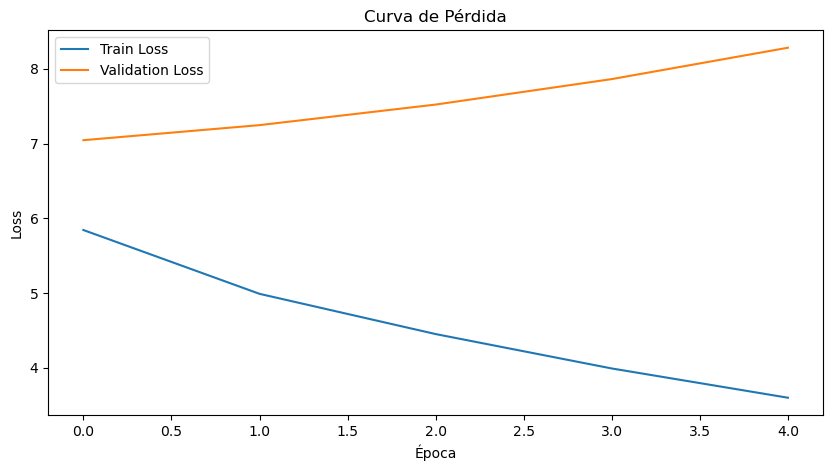

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva de Pérdida")
plt.legend()
plt.show()


Como se puede observar, la curva de pérdida en el entrenamiento baja a un ritmo constante, por lo que se puede decir que el modelo aprende y se ajusta muy bien a los datos de entrenamiento. 

Por otra parte, la curva de color naranja nos indica la pérdida en validación y se observa que en lugar de que este baje, sube en cada época. En general se dice que este modelo empeora con la validación. 

Gráfica para accuracy

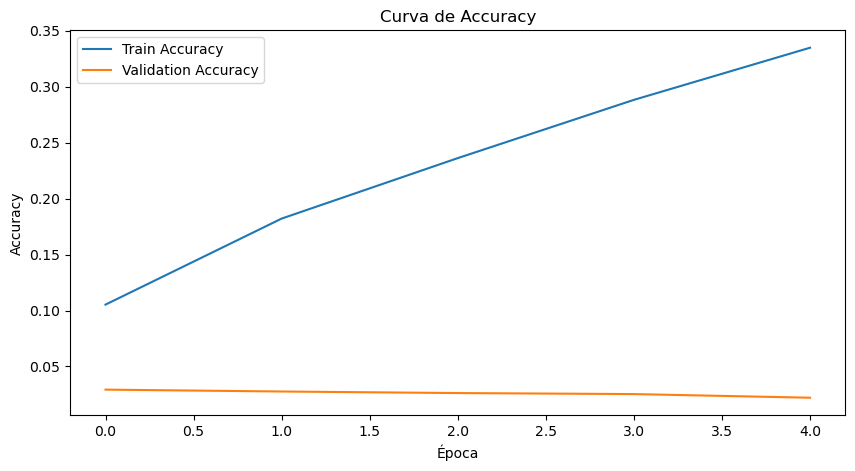

In [23]:
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Curva de Accuracy")
plt.legend()
plt.show()

Al igual que la anterior gráfica, la curva de accuracy en entrenamiento muestra un aprendizaje significativo, mientras que la curva de accuracy en validación se mantiene baja y no mejora, lo que indica nuevamente que el modelo no generaliza bien las predicciones. 

Ejemplos de generación de texto

In [24]:
phrases = ["I love", "The Sun", "Music is"]
STRING_LEN = 8

for phrase in phrases:
    text_input = phrase
    print(f"\Entrada: '{phrase}'")
    for i in range(STRING_LEN):
        predicted_word = predict_next_word(model, tokenizer, text_input, WINDOW_SIZE)
        text_input += ' ' + predicted_word
    print("Texto generado:", text_input)


\Entrada: 'I love'
Texto generado: I love you i love you i love you i
\Entrada: 'The Sun'
Texto generado: The Sun we 're standing on the sun standing on
\Entrada: 'Music is'
Texto generado: Music is all the things you do n't have to


### Conclusión 
En este trabajo se realizó una implementación de un modelo de predicción de la siguiente palabra utilizando un corpus de letras de canciones en inglés y un modelo básico de MLP con embeddings. 

Los resultados muestran que el modelo tiene buen rendimiento en el conjunto de entrenamiento pero sucede lo contrario en la evaluación en el conjunto de validación y además la perplejidad se dispara, lo que parece indicar que el modelo está memorizando y no aprendiendo o generalizando correctamente. Esto puede deberse al modelo básico empleado y al número de épocas utilizadas o una combinación de las mismas. 